In [1]:
import numpy as np
import pandas as pd
import cPickle
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Reading tweets

In [2]:
ttk_train = pd.read_csv('../data/ttk_train.csv', sep='\t', encoding='utf-8')

In [3]:
ttk_train.head()

,id,text,label
0,1,"@mkomov Максим, Вашем письмо мы получили. Наши...",0
1,2,«Мегафон» стал владельцем 50% акций «Евросети»,0
2,3,RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...,-1
3,4,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...,1
4,5,"@parfenov1960 потому что МТС достало, а пчел н...",-1


In [4]:
texts, labels = ttk_train.text.values, ttk_train.label.values

### Reading vocabulary and embeddings

In [5]:
word2id, embeddings = cPickle.load(open('../data/w2v/vectors_l.pkl', 'rb'))
# word2id, embeddings = cPickle.load(open('../data/w2v/parkin_vectors.pkl', 'rb'))

In [6]:
vocabulary = word2id.keys()
eos_id = word2id[u'</s>']

### Lemmatizing and replacing words with ids

In [7]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(u'[а-яА-Я]+')
morph = pymorphy2.MorphAnalyzer()

def text2seq(text):
    tokens_norm = [morph.parse(w)[0].normal_form for w in tokenizer.tokenize(text)]
    return [word2id[w] for w in tokens_norm if w in vocabulary] + [eos_id]

sample = texts[49]

print sample
print u' '.join(tokenizer.tokenize(sample))
print u' '.join([morph.parse(w)[0].normal_form for w in tokenizer.tokenize(sample)])
print text2seq(sample)

RT @_Beeline_kz: Сегодня День Системного Администратора! =) С праздником, друзья! http://t.co/KiDNwq11ht
Сегодня День Системного Администратора С праздником друзья
сегодня день системный администратор с праздник друг
[199, 132, 4460, 9519, 8, 790, 134, 0]


In [8]:
%%time
pool = multiprocessing.Pool()
X = pool.map(text2seq, texts)

CPU times: user 152 ms, sys: 72 ms, total: 224 ms
Wall time: 1min 10s


Dumping

In [9]:
cPickle.dump(X, open('../data/X_ttk_train_full.pkl', 'wb'))

Loading

In [8]:
X = cPickle.load(open('../data/X_ttk_train_full.pkl', 'rb'))

Distribution of sequences' lengths 

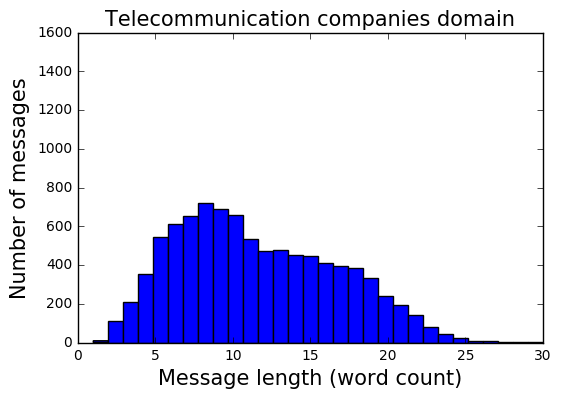

In [9]:
length_max = max(map(len, X))
plt.hist(map(len, X), bins=length_max)
plt.title("Telecommunication companies domain", fontsize=15)
plt.xlabel("Message length (word count)", fontsize=15)
plt.ylabel("Number of messages", fontsize=15)
plt.ylim(0, 1600)
plt.show()

### Zero padding

In [10]:
X = [x + [eos_id]*(length_max - len(x)) for x in X]

### Examples

In [11]:
for x in X[:4]:
    print x

[528, 70, 1183, 21, 198, 55, 858, 6752, 8, 13, 946, 1, 1287, 3426, 2728, 43, 2029, 15730, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[14010, 93, 2128, 766, 25756, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[12405, 32, 1027, 310, 54912, 1294, 2, 33, 6522, 302, 581, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[628, 1514, 8, 2634, 12405, 2171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Split into train and validation sets

In [12]:
X = np.array(X)
y = ttk_train.label.values

In [13]:
def cls2probs(cls):
    if cls == -1:
        return [1.,0.,0.]
    elif cls == 0:
        return [0.,1.,0.]
    else:
        return [0.,0.,1.]
y = np.array([cls2probs(cls) for cls in y])

In [14]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [15]:
print "Train class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_tr.transpose()]
print "Validation class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()]
print "Constant classifier's validation accuracy:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()][1] * 1. / y_val.shape[0]

Train class frequencies:	[2370, 4686, 1232]
Validation class frequencies:	[241, 527, 153]
Constant classifier's validation accuracy:	0.57220412595


### Resampling

# Network learning

In [18]:
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import LSTMCell, GRUCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.layers import fully_connected

from utils import *

In [20]:
y_pred_major = np.zeros(y_val.shape)
y_pred_major[:,0] = 1.
print "Constant classifier's F-score on validation set:", f_macro(y_val, y_pred_major)

Constant classifier's F-score on validation set: 0.207401032702


### Bi-RNN

In [49]:
EMBED_DIM = 300
HIDDEN_SIZE = 300
NUM_CLASSES = 3

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, None])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)
batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)
    
# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(2, outputs)
# outputs2,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs2 = tf.concat(2, outputs2)

# Last output of Bi-RNN
output = outputs[:,0,:]

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [51]:
# Adam parameters
LEARNING_RATE = 1e-4
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, target_ph), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
                                   epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.MomentumOptimizer(learning_rate=2e-1, momentum=0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 99
	 Train loss: 0.218	 ce: 0.218	 acc: 0.938	 f_macro: 0.895
	 Valid loss: 0.958	 ce: 0.958	 acc: 0.741	 f_macro: 0.620


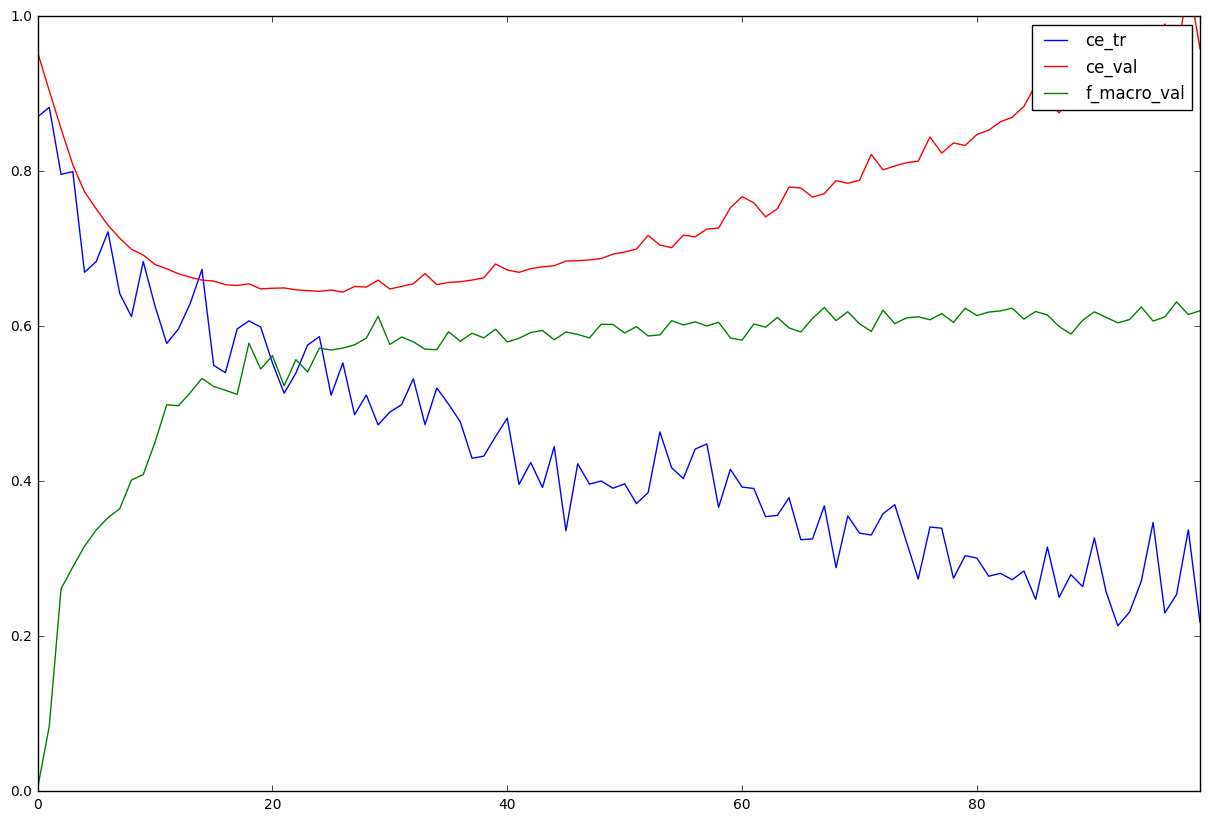

In [52]:
from sklearn.model_selection import StratifiedKFold, KFold

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 100

skf = KFold(5, shuffle=True, random_state=42)

results = []

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []
    min_ce = 0.32

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
            y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})


            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
    results.append([acc_val_l[-1], f_macro_val_l[-1]])

In [37]:
min(ce_val_l), max(acc_val_l), max(f_macro_val_l)

(0.79121876, 0.67804873, 0.5352049762925896)

---

### Bi-RNN with Attention mechanism

Attention mechanism formulas and notation
$$
\upsilon_{t}=\tanh{(W_{\omega}\left[\overrightarrow{h_{t}},\overleftarrow{h_{t}}\right]+b_{\omega})}\\
\alpha_{t}=\frac{\exp{(\upsilon_{t}^{T}u_{\omega})}}{\sum_{j=1}^{T}\exp{(\upsilon_{j}^{T}u_{\omega})}}\\
\upsilon=\sum_{t=1}^{T}\alpha_{t}h_{t}	
$$

In [41]:
EMBED_DIM = 300
SEQ_LENGTH = length_max
HIDDEN_SIZE = 300
ATTENTION_SIZE = 100
NUM_CLASSES = 3

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, SEQ_LENGTH])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)

batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)

# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(2, outputs)
# outputs2,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs2 = tf.concat(2, outputs2)

# Attention mechanism
W_omega = tf.Variable(tf.random_normal([2 * HIDDEN_SIZE, ATTENTION_SIZE], stddev=0.1))
b_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))
u_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))

v = tf.tanh(tf.matmul(tf.reshape(outputs, [-1, 2 * HIDDEN_SIZE]), W_omega) + tf.reshape(b_omega, [1, -1]))
vu = tf.matmul(v, tf.reshape(u_omega, [-1, 1]))
exps = tf.reshape(tf.exp(vu), [-1, SEQ_LENGTH])
alphas = exps / tf.reshape(tf.reduce_sum(exps, 1), [-1, 1])

# Output of Bi-RNN reduced with attention vector
output = tf.reduce_sum(outputs * tf.reshape(alphas, [-1, SEQ_LENGTH, 1]), 1)

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [42]:
# Adam parameters
LEARNING_RATE = 1e-4
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, target_ph), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
                                   epsilon=EPSILON).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 99
	 Train loss: 0.232	 ce: 0.232	 acc: 0.918	 f_macro: 0.865
	 Valid loss: 1.174	 ce: 1.174	 acc: 0.739	 f_macro: 0.613


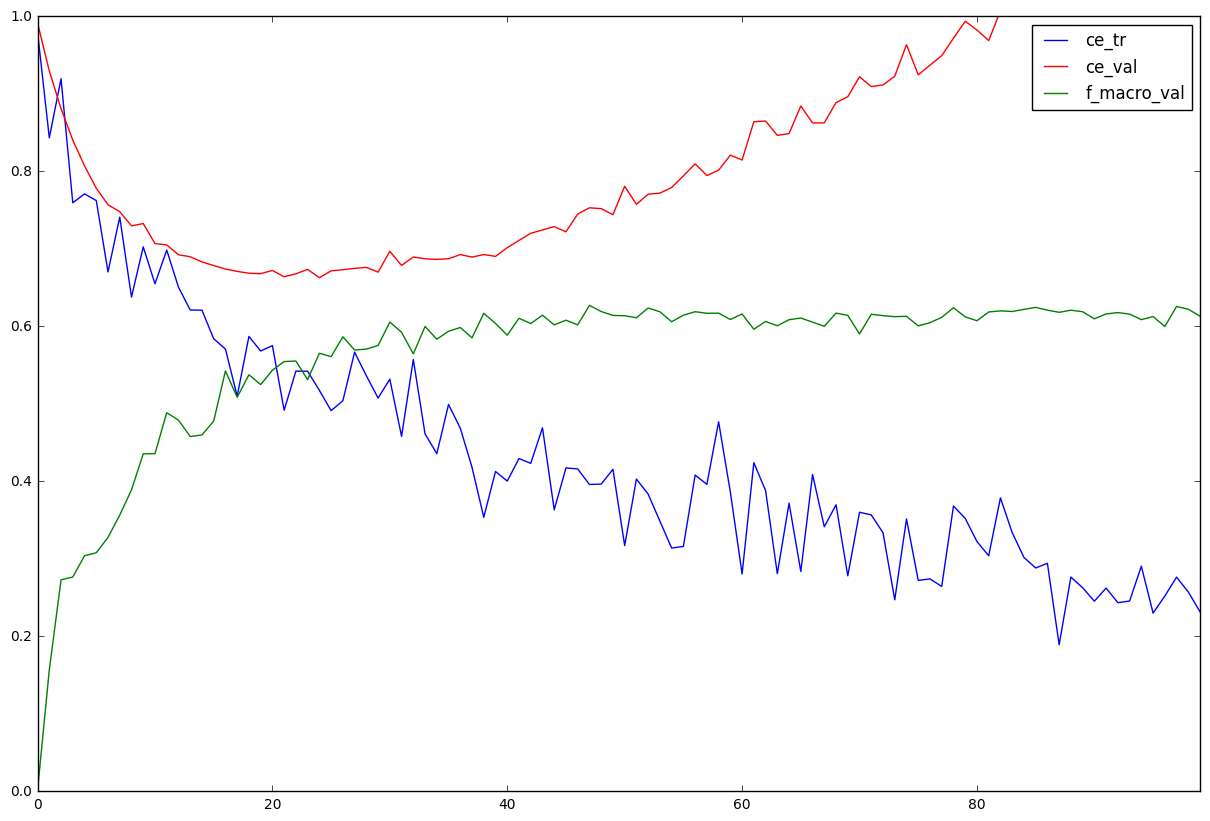

In [43]:
from sklearn.model_selection import StratifiedKFold, KFold

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 100

skf = StratifiedKFold(5, shuffle=True, random_state=42)
skf = KFold(5, shuffle=True, random_state=42)

results = []

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []
    min_ce = 0.32

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
            y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})


            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
    results.append([acc_val_l[-1], f_macro_val_l[-1]])

In [63]:
min(ce_val_l), max(acc_val_l), max(f_macro_val_l)

(0.78584206, 0.67601621, 0.5259712191834366)

---

---

---

# Testing

In [23]:
ttk_test = pd.read_csv('../data/ttk_test.csv', sep='\t', encoding='utf-8')
texts_test, labels_test = ttk_test.text.values, ttk_test.label.values

In [33]:
%%time
pool = multiprocessing.Pool()
X_test = pool.map(text2seq, texts_test)
cPickle.dump(X_test, open('../data/X_ttk_test.pkl', 'wb'))

CPU times: user 148 ms, sys: 216 ms, total: 364 ms
Wall time: 20 s


In [24]:
X_test = cPickle.load(open('../data/X_ttk_test.pkl', 'rb'))

In [25]:
X_test = [x[:length_max - 1] + [eos_id]*(length_max - min(len(x), length_max - 1)) for x in X_test]
X_test = np.array(X_test)
y_test = np.array([cls2probs(cls) for cls in labels_test])

In [57]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model_attention_momentum.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in X_test])
    y_pred_test, ce_test, loss_test, acc_test = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                     feed_dict={batch_ph: X_test, target_ph: y_test,
                                                                seq_len_ph: seq_len_test, keep_prob_ph: 1.0})
    seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
    y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})

In [58]:
y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)
print f_macro_val, f_micro_val

0.604846676271 0.669286182056


In [59]:
y_pred_test = np.array([cls2probs(cls) for cls in np.argmax(y_pred_test, 1) - 1])
f_macro_test, f_micro_test = f_macro(y_test, y_pred_test), f_micro(y_test, y_pred_test)
print f_macro_test, f_micro_test

0.489677406107 0.654517843584
